### Import modules

In [1]:
import lightning as L
from lightning.pytorch.callbacks import ModelSummary, ModelCheckpoint
from lightning.pytorch.tuner import Tuner

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
from model import TransformerModel
from dataset import TranslationDataModule
from config import get_config

conf = get_config()

### Import the Datamodule & Initialize

In [4]:
datamodule = TranslationDataModule(conf)
src_seq_len, tgt_seq_len = datamodule.get_seq_lens()
datamodule.setup()

Max length of source sentence: 150
Max length of target sentence: 159


### Initialize Model & Trainer

In [5]:
model = TransformerModel(
    src_vocab_size=datamodule.tokenizer_src.get_vocab_size(),
    tgt_vocab_size=datamodule.tokenizer_tgt.get_vocab_size(),
    src_seq_len=src_seq_len+2,
    tgt_seq_len=tgt_seq_len+1,
    d_model=conf["d_model"],
    tokenizer_src=datamodule.tokenizer_src,
    tokenizer_tgt=datamodule.tokenizer_tgt,
    learning_rate=conf["lr"],
    max_lr=conf["lr"],
    epochs=conf["num_epochs"],
    steps=len(datamodule.train_dataloader()),
)

In [6]:
callbacks = [
    ModelSummary(max_depth=3),
    ModelCheckpoint(
        dirpath="model_checkpoints",
        filename="tr_{epoch}",
        monitor="train_loss",
        mode="min",
        save_last=True,
    ),
]

In [7]:
trainer = L.Trainer(
    accelerator="gpu",
    devices=[1],
    num_nodes=1,
    precision="16-mixed",
    max_epochs=conf["num_epochs"],
    callbacks=callbacks,
    check_val_every_n_epoch=20,
)

Using 16bit Automatic Mixed Precision (AMP)
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Find the best learning rate

You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.001584893192461114
Restoring states from the checkpoint path at /home/ravi.naik/learning/era/s16/.lr_find_0fdf20ee-f45c-496b-90b0-10a3b74dd91c.ckpt
Restored all states from the checkpoint at /home/ravi.naik/learning/era/s16/.lr_find_0fdf20ee-f45c-496b-90b0-10a3b74dd91c.ckpt


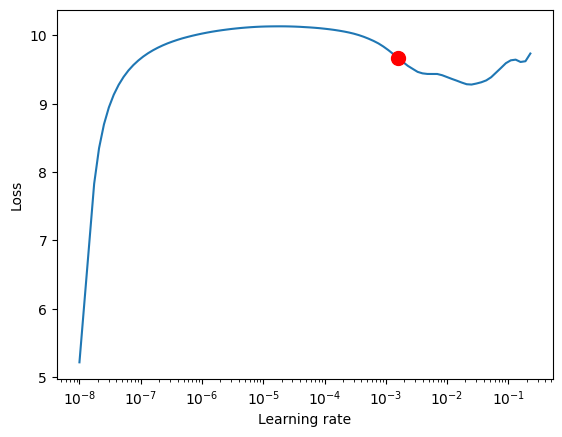

In [8]:
tuner = Tuner(trainer)

lr_finder = tuner.lr_find(model=model, datamodule=datamodule)
maxlr = lr_finder.suggestion()
fig = lr_finder.plot(suggest=True)

### Updated the optimum LR & Begin training

In [ ]:
model.learning_rate = maxlr
model.maxlr = maxlr

trainer.fit(model=model, datamodule=datamodule)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name                                    | Type               | Params
--------------------------------------------------------------------------------
0  | transformer                             | Transformer        | 68.1 M
1  | transformer.encoder                     | Encoder            | 9.4 M 
2  | transformer.encoder.layers              | ModuleList         | 9.4 M 
3  | transformer.encoder.norm                | LayerNormalization | 2     
4  | transformer.decoder                     | Decoder            | 12.6 M
5  | transformer.decoder.layers              | ModuleList         | 12.6 M
6  | transformer.decoder.norm                | LayerNormalization | 2     
7  | transformer.src_embed                   | InputEmbeddings    | 15.4 M
8  | transformer.src_embed.embedding         | Embedding          | 15.4 M
9  | transformer.tgt_embed                   | InputEmbeddings    | 15.4 M
10 | transformer.tgt_embed.embedding         | Em

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]